In [1]:
import os
import scanpy as sc
import scvelo as scv
import pandas as pd

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "110"  # 设置OpenMP线程数为110
os.environ["MKL_NUM_THREADS"] = "110" 

In [5]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Use CPU

# Move your model and data to the device
model.to(device)
data = data.to(device)

NameError: name 'model' is not defined

In [7]:
import cellrank as cr

In [9]:
import omicverse as ov


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.8, Tutorials: https://omicverse.readthedocs.io/


In [11]:
adata = sc.read_h5ad('D:/velocity_adata2.h5ad')

In [13]:
mito_genes = adata.var_names.str.startswith('mt-')
adata = adata[:, ~mito_genes].copy()

In [15]:
ov.plot_set()

Dependency error: (ipywidgets 7.8.1 (c:\programdata\anaconda3\lib\site-packages), Requirement.parse('ipywidgets>=8.0'))


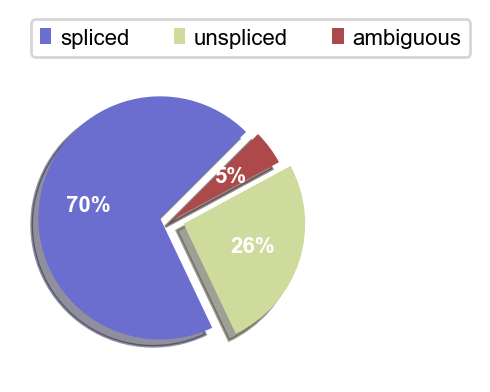

In [17]:
scv.pl.proportions(adata)

In [19]:
adata.obs['velocity_pseudotime_EMmodel']=adata.obs['velocity_pseudotime'].copy()

In [21]:
from velovi import VELOVI

VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

# 训练模型，并指定使用GPU和核心数
vae.train(max_epochs=50, lr=0.01, weight_decay=0.01, accelerator='auto', devices='auto')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
import torch
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [ ]:
scv.tl.velocity_graph(adata, n_jobs=118)
scv.pl.velocity_embedding_stream(adata, basis="umap")

In [ ]:
scv.tl.latent_time(adata)
adata.obs['latent_time_velovi']=adata.obs['latent_time'].copy()

In [ ]:
adata.obs['velocity_pseudotime_velovi']=adata.obs['velocity_pseudotime'].copy()

In [ ]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['latent_time_EMmodel','latent_time_velovi'],
                   frameon='small',cmap='Reds')